# Imports

In [1]:
import pandas as pd
import numpy as np
import string
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from bitarray import bitarray    ## bitArray for bits: used in bloom filter
import mmh3                      ## hash function
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


# Read CSV data

In [2]:
attribute = pd.read_csv('attributes.csv')
attribute['Attributes'].replace(regex=True,inplace=True,to_replace=r':',value=r'')
list_a = attribute['Attributes'].tolist()
list_a = [x.strip(' ') for x in list_a] 
list_a.append('target')
file = pd.read_csv('spambase.data',header=None,names=list_a,skip_blank_lines=True)
filep = np.array(file)
data = filep[:,0:-1]
target = filep[:,-1]

spam_tuples = (file.target == 1)
non_spam_tuples = (file.target==0)
spam_emails = file.loc[spam_tuples,list_a]
#spam_tuples.shape
spam_emails.shape

(1813, 58)

# Train_Test_Split

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, train_size=0.67, test_size=0.33)
X_train = data  # fixed for both Logistic & NN
Y_train = target

# Logistic Regression

In [4]:
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred_test = model.predict(X_test)
accuracy = accuracy_score(Y_test,Y_pred_test)
Y_prob = model.predict_proba(X_test)

### Accuracy of Logistic Regression: Over Various Threshold


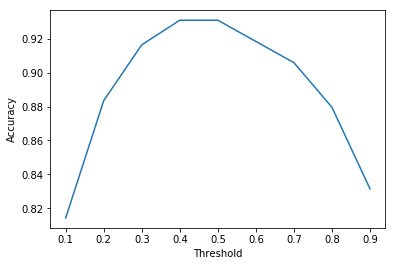

In [5]:
accuracy_tao = []
tao = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]  # various threshold limit for controlling FPR
for id,t in enumerate(tao):
    Y_pred_test_tao = []
    for i in range(Y_prob.shape[0]):
        if(Y_prob[i,1] >= t):
            Y_pred_test_tao.append(1)
        else:
            Y_pred_test_tao.append(0)
    accuracy = accuracy_score(Y_test,Y_pred_test_tao)
    accuracy_tao.append(accuracy)
plt.plot(tao,accuracy_tao)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

## Building bloom filter : Traditional 

In [6]:
def build_bloom_filter(FPR,data):
    string_data = []                                     ## CONVERT DATA TO STRING LIST
    n = len(data)
    for i in range(0,n):
        string_data.append(''.join(str(e) for e in data[i]))
        for char in string.punctuation:
            string_data[i] = string_data[i].replace(char, '')
    m = int((n * math.log(1/FPR))/(math.log(2)**2))      ## calculating the size 'm' of bloom filter
    k = math.ceil(m/n * math.log(2))                    ## calculating the number of hash function required
    bloom = bitarray(m)                                 ## create a bitarray for the above mentioned 'm'
    bloom.setall(0)
    list_index=[]                                       ## build the bloom filter-- note down the indexes generated
    for s in string_data:
        for i in range(k):
            index = mmh3.hash(s,i)%m
            if bloom[index] == 0:
                bloom[index] = 1
    return bloom,m

## Building Bloom Filter : Learned

In [7]:
# Building and training phase of Bloom filter
def build_learned_bloom(FPR,data):
    string_data = []                                     # storing DATA in STRING format and storing in this LIST
    n = len(data)
    for i in range(0,n):
        string_data.append(''.join(str(e) for e in data[i]))
        for char in string.punctuation:
            string_data[i] = string_data[i].replace(char, '')
    m = int((n * math.log(1/FPR))/(math.log(2)**2))      ## calculating the size 'm':bloom filter
    k = math.ceil(m/n * math.log(2))                     ## calculating the number of hash function required
      
    bloom = bitarray(m)                                 ## create a bitarray for the above mentioned 'm'
    bloom.setall(0)
    list_index=[]                                       ## build the bloom filter-- note down the indexes generated
    for s in string_data:
        for i in range(k):
            index = mmh3.hash(s,i)%m
            if bloom[index] == 0:
                bloom[index] = 1
    return bloom,m,k

## Given Key Check Existence (Testing Phase):  Bloom filter

In [8]:
def check_In_Bloom(bloom,X_test,Y_test,bloom_size,hash_count):
    string_data = []                                     ## CONVERT DATA TO STRING LIST
    n = len(X_test)
    for i in range(0,n):
        string_data.append(''.join(str(e) for e in X_test[i]))
        for char in string.punctuation:
            string_data[i] = string_data[i].replace(char, '')
    m = bloom_size
    k = hash_count
    false_negative = 0
    false_positive = 0
    for index in range(0,n):
        present=True
        for i in range(0,k):
            idx = mmh3.hash(string_data[index],i)%m
            if (bloom[idx] == 0):
                present = False
                break
        if (present == False and Y_test[index] == 1):
            false_negative = false_negative + 1
        elif (present == True and Y_test[index] == 0):
            false_positive = false_positive + 1
    return (false_negative/n), (false_positive/n)

## Training + Testing Learned(Logistic) bloom filter over different thresholds (tao)

In [9]:
# Collecting data for Bloom filter to train
FPR_clf = []
FNR_clf = []
FPR_bloom = []
FNR_bloom = []
original_bloom_size = []
learned_bloom_size = []
Y_prob = model.predict_proba(X_train)[:,1]
for id,t in enumerate(tao):
    bloom_data = [];
    false_positive = 0      # of classifier
    false_negative = 0      # of classifier
    for i in range(0,Y_prob.shape[0]):
        if(Y_prob[i] >= t and Y_train[i] == 0): # this is false positive
            false_positive = false_positive + 1
        elif(Y_prob[i] < t and Y_train[i] == 1): # spam may considered as non-spam : pass these to bloom filter
            bloom_data.append(X_train[i])
            false_negative = false_negative + 1
    
    false_positive = false_positive / X_train.shape[0]
    false_negative = false_negative / X_train.shape[0]
    FPR_clf.append(false_positive)
    FNR_clf.append(false_negative)
    
    # Normal Bloom Filter
    b,size_O = build_bloom_filter(false_positive,data)
    original_bloom_size.append(size_O)
    
    # learned bloom filter: Model + Bloom Filter
    bloom,bloom_size,hash_count = build_learned_bloom(false_positive,bloom_data)
    learned_bloom_size.append(bloom_size)
    
    # Check In Bloom: Preparing Test data for overflow Bloom filter and calling of function
    bloom_test_data = []
    bloom_test_true_label = []
    Y_prob_test = model.predict_proba(X_test)[:,1]
    for i in range(Y_prob_test.shape[0]):
        if(Y_prob_test[i] < t):
            bloom_test_data.append(X_test[i]) 
            bloom_test_true_label.append(Y_test[i])
    FNR, FPR = check_In_Bloom(bloom,bloom_test_data,bloom_test_true_label,bloom_size,hash_count)
    FPR_bloom.append(FPR)
    FNR_bloom.append(FNR)

##  Plotting of graphs : Logistic

### FPR vs FNR

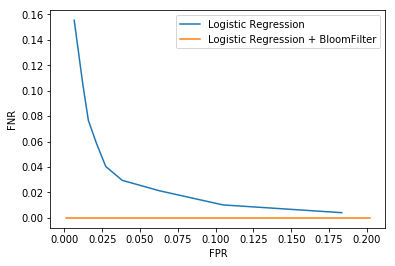

In [10]:
plt.plot(FPR_clf,FNR_clf,label='Logistic Regression')
plt.plot(FPR_bloom,FNR_bloom,label='Logistic Regression + BloomFilter')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.legend(prop={'size': 10})
plt.show()


### FPR : Learned Bloom filter vs Classifier over thresholds

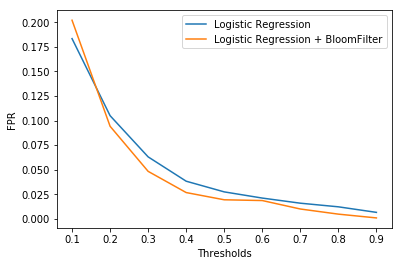

In [11]:
plt.plot(tao,FPR_clf,label='Logistic Regression')
plt.plot(tao,FPR_bloom,label='Logistic Regression + BloomFilter')
plt.xlabel('Thresholds')
plt.ylabel('FPR')
plt.legend(prop={'size': 10})
plt.show()

### FNR : Learned Bloom filter vs Classifier over thresholds

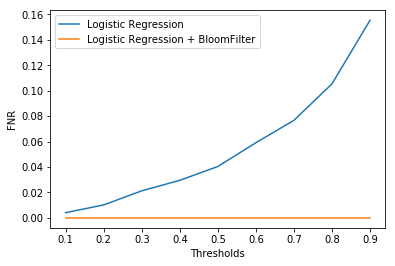

In [12]:
plt.plot(tao,FNR_clf,label='Logistic Regression')
plt.plot(tao,FNR_bloom,label='Logistic Regression + BloomFilter')
plt.xlabel('Thresholds')
plt.ylabel('FNR')
plt.legend(prop={'size': 10})
plt.show()

### FPR  vs BloomFilter Size: Learned Bloom filter vs Traditional Bloom

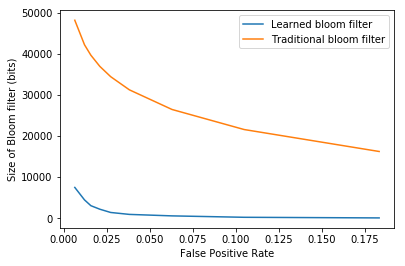

In [13]:
plt.plot(FPR_clf,learned_bloom_size,label='Learned bloom filter')
plt.plot(FPR_clf,original_bloom_size,label='Traditional bloom filter')
plt.legend(prop={'size': 10})
plt.xlabel('False Positive Rate')
plt.ylabel('Size of Bloom filter (bits)')
plt.show()

# Neural Network Model

In [15]:
neural_model = Sequential()
neural_model.add(Dense(units = 57,input_dim = 57,use_bias=True))
neural_model.add(Dense(units = 4,use_bias=True))
neural_model.add(Dense(units = 1,activation='sigmoid',use_bias=True))
sgd= SGD(lr=0.01)
neural_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
neural_model.fit(X_train,Y_train,epochs = 100 , batch_size=50)

Epoch 1/100
4601/4601 [==============================] - 0s 73us/step - loss: 2.3258 - acc: 0.5777
Epoch 2/100
4601/4601 [==============================] - 0s 38us/step - loss: 1.0664 - acc: 0.6620
Epoch 3/100
4601/4601 [==============================] - 0s 40us/step - loss: 1.3623 - acc: 0.6257
Epoch 4/100
4601/4601 [==============================] - 0s 40us/step - loss: 0.9882 - acc: 0.6644
Epoch 5/100
4601/4601 [==============================] - 0s 40us/step - loss: 0.7007 - acc: 0.7088
Epoch 6/100
4601/4601 [==============================] - 0s 40us/step - loss: 0.6191 - acc: 0.7066
Epoch 7/100
4601/4601 [==============================] - 0s 40us/step - loss: 0.8688 - acc: 0.6920
Epoch 8/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.6091 - acc: 0.7151
Epoch 9/100
4601/4601 [==============================] - 0s 40us/step - loss: 0.6009 - acc: 0.7114
Epoch 10/100
4601/4601 [==============================] - 0s 41us/step - loss: 0.5993 - acc: 0.7103
Epoch 11/

### Calculating probabilities from neural network model

In [16]:
Y_prob_NN = neural_model.predict(X_train)

## Training + Testing Learned(Neural Network) bloom filter over different thresholds (tao)

In [17]:
FPR_NN = []
FNR_NN = []
FPR_bloom_NN = []
FNR_bloom_NN = []
NN_bloom_size = []  # NN + bloom: bloom size
ONN_bloom_size = []
tao_NN  = [0.35,0.45,0.55,0.65,0.75,0.85,0.95]
for id,t in enumerate(tao_NN):
    bloom_data_NN = [];
    false_positive = 0      # of classifier
    false_negative = 0      # of classifier
    for i in range(0,Y_prob_NN.shape[0]):
        if(Y_prob_NN[i] >= t and Y_train[i] == 0): # this is false positive
            false_positive = false_positive + 1
        elif(Y_prob_NN[i] < t and Y_train[i] == 1): # spam may considered as non-spam : pass these to bloom filter
            bloom_data_NN.append(X_train[i])
            false_negative = false_negative + 1
    false_positive = false_positive / X_train.shape[0]
    false_negative = false_negative / X_train.shape[0]
    FPR_NN.append(false_positive)
    FNR_NN.append(false_negative)
    
    # Normal Bloom Filter
    b,size_O = build_bloom_filter(false_positive,data)
    ONN_bloom_size.append(size_O)
    
    # learned bloom filter: Model + Bloom Filter
    bloom,bloom_size,hash_count = build_learned_bloom(false_positive,bloom_data_NN)
    NN_bloom_size.append(bloom_size)
    
    # Check In Bloom: Preparing Test data for overflow Bloom filter and calling of function
    bloom_test_data = []
    bloom_test_true_label = []
    Y_prob_test = neural_model.predict(X_test)
    for i in range(Y_prob_test.shape[0]):
        if(Y_prob_test[i] < t):
            bloom_test_data.append(X_test[i]) 
            bloom_test_true_label.append(Y_test[i])
    FNR, FPR = check_In_Bloom(bloom,bloom_test_data,bloom_test_true_label,bloom_size,hash_count)
    FPR_bloom_NN.append(FPR)
    FNR_bloom_NN.append(FNR)

### FPR vs FNR

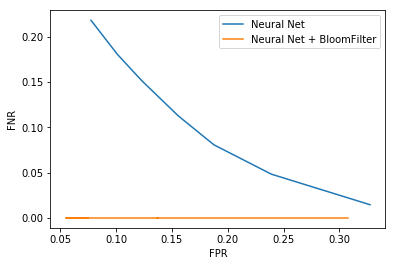

In [105]:
plt.plot(FPR_NN,FNR_NN,label='Neural Net')
plt.plot(FPR_bloom_NN,FNR_bloom_NN,label='Neural Net + BloomFilter')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.legend(prop={'size': 10})
plt.show()

### FPR : Learned Bloom filter vs Classifier over thresholds

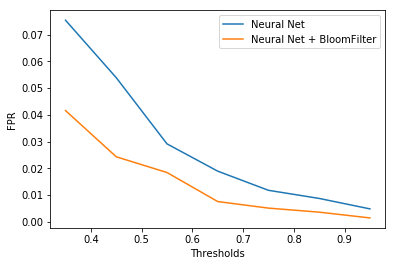

In [18]:
plt.plot(tao_NN,FPR_NN,label='Neural Net')
plt.plot(tao_NN,FPR_bloom_NN,label='Neural Net + BloomFilter')
plt.xlabel('Thresholds')
plt.ylabel('FPR')
plt.legend(prop={'size': 10})
plt.show()

### FNR : Bloom filter vs Neural net over thresholds

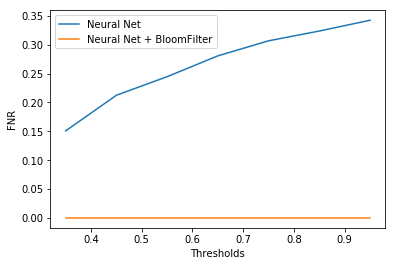

In [19]:
plt.plot(tao_NN,FNR_NN,label='Neural Net')
plt.plot(tao_NN,FNR_bloom_NN,label='Neural Net + BloomFilter')
plt.xlabel('Thresholds')
plt.ylabel('FNR')
plt.legend(prop={'size': 10})
plt.show()

### FPR  vs BloomFilter Size: Learned Bloom filter vs Traditional Bloom

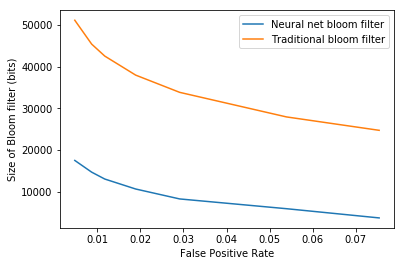

[3733, 5945, 8287, 10670, 13063, 14715, 17526]

In [20]:
plt.plot(FPR_NN,NN_bloom_size,label='Neural net bloom filter')
plt.plot(FPR_NN,ONN_bloom_size,label='Traditional bloom filter')
plt.legend(prop={'size': 10})
plt.xlabel('False Positive Rate')
plt.ylabel('Size of Bloom filter (bits)')
plt.show()